# Test and Trial on Gaussian Mixture Distribution.

In [1]:
%matplotlib inline

import sys
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.contrib.distributions import (
    Categorical, NormalWithSoftplusScale, Mixture)

from nn4post import InferenceBuilder
try:
    from tensorflow.contrib.distributions import Independent
except:
    print('WARNING - Your TF < 1.4.0.')
    from nn4post.utils.independent import Independent

/Users/shuiruge/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# For reproducibility
SEED = 123456
tf.set_random_seed(SEED)
np.random.seed(SEED)

## Functions

In [3]:
def make_log_posterior(target_c, target_mu, target_zeta):
  
    target_c = tf.convert_to_tensor(target_c)
    target_mu = tf.convert_to_tensor(target_mu)
    target_zeta = tf.convert_to_tensor(target_zeta)

    # -- Gaussian Mixture Distribution
    with tf.name_scope('posterior'):

      cat = Categorical(probs=target_c)
      components = [
          Independent(
              NormalWithSoftplusScale(target_mu[i], target_zeta[i])
          ) for i in range(target_c.shape[0])
      ]
      p = Mixture(cat, components)

      def log_posterior(theta):
          return p.log_prob(theta)

    return log_posterior

In [4]:
def shall_stop(loss_values, tolerance, n_means=20):
    """Returns `True` if the relative variance of loss-value in
    `loss_values` becomes smaller than `tolerance`, else `False`.
    The loss-value is smeared by its nearby `n_means` loss-values.
    """
    if len(loss_values) < 2 * n_means:
        return False

    else:
        previous_loss = np.mean(loss_values[-2*n_means:-n_means])
        current_loss = np.mean(loss_values[-n_means:])
        delta_loss = previous_loss - current_loss
        relative_delta_loss = abs( delta_loss / (current_loss + 1e-8) )

        if relative_delta_loss < tolerance:
            return True
        else:
            return False


def test(target_c, target_mu, target_zeta, init_var,
         tolerance=1e-2, n_iters=None, **inference_kwargs):
    """Test on Gaussian mixture distribution as the target.
    
    Args:
        target_c: Numpy array.
        target_mu: Numpy array.
        target_zeta: Numpy array.
        init_var: Dictionary with keys: "a", "mu", and "zeta" and
            values numpy arraies.
        XXX
            `n_iters` is more preferable than `tolerance`.
        inference_kwargs: Dictionary, as the kwargs (parameters)
            of `InferenceBuilder.__init__()`.
    
    Returns:
        Dictionary with keys: "loss", "a", "mu", and "zeta", and
        values the values at each iteration, collected in a list.
    """

    tf.reset_default_graph()

    log_p = make_log_posterior(target_c, target_mu, target_zeta)

    n_c, n_d = init_var['mu'].shape
    ib = InferenceBuilder(n_c, n_d, log_p, **inference_kwargs)
    
    a = tf.Variable(init_var['a'], dtype='float32')
    mu = tf.Variable(init_var['mu'], dtype='float32')
    zeta = tf.Variable(init_var['zeta'], dtype='float32')
    loss, gradients = ib.make_loss_and_gradients(a, mu, zeta)

    optimizer = tf.train.RMSPropOptimizer(0.05)
    #optimizer = tf.train.AdamOptimizer(0.005)
    train_op = optimizer.apply_gradients(gradients)
    
    init = tf.global_variables_initializer()

    with tf.Session() as sess:
        
        sess.run(init)

        test_result = {'loss': [], 'a': [], 'mu': [], 'zeta': []}
        step = 0
            
        def iter_body():
            
            nonlocal step

            _, loss_val, a_val, mu_val, zeta_val \
                = sess.run([train_op, loss, a, mu, zeta])

            test_result['loss'].append(loss_val)
            test_result['a'].append(a_val)
            test_result['mu'].append(mu_val)
            test_result['zeta'].append(zeta_val)
            
            step += 1
            if (step+1) % 100 == 0:
                print(step, loss_val)

        if n_iters:
            for i in range(n_iters):
                iter_body()
                
        else:
            while not shall_stop(test_result['loss'], tolerance):
                iter_body()
                
    return test_result

In [5]:
# Helpers

def softplus(x, limit=10.):
    return np.where(x<limit, np.log(1. + np.exp(x)), x)


def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)


def plot_trajectory(trajectory, i=0, j=1):
    """Plot the 2D projection of the trajectory `trajectory`.
    
    Args:
        trajectory: List of 2D numpy array.
        i: Integer, as the x-axis to be plotted, optional.
        j: Integer, as the y-axis to be plotted, optional.
    """
    n_points = len(trajectory)
    x = [_[i] for _ in trajectory]
    y = [_[j] for _ in trajectory]
    delta_x = [x[i+1] - x[i] for i in range(n_points-1)]
    delta_y = [y[i+1] - y[i] for i in range(n_points-1)]
    plt.quiver(x, y, delta_x, delta_y)

## Experiments

### The Effect of $\beta$

#### Configuration

In [28]:
n_d = 1000
ones = np.ones([n_d]).astype('float32')
target_c = np.array([0.7, 0.25, 0.05]).astype('float32')
target_mu = np.array([-2*ones, 0*ones, 2*ones]).astype('float32')
target_zeta = np.array([ones, ones, ones]).astype('float32')

n_c = 10
init_var = {
    'a': np.zeros([n_c]).astype('float32'),
    'mu': np.random.normal(0., 30., size=[n_c, n_d]).astype('float32'),
    'zeta': np.zeros([n_c, n_d]).astype('float32'),
}

init_var['mu'][0] = -2 * np.ones([n_d]).astype('float32')

tolerance = 1e-3
n_iters = 2000

#### Experiment

* When $\beta = 0$

In [16]:
%%time

test_result_0 = test(target_c, target_mu, target_zeta,init_var,
                     tolerance=tolerance, n_iters=n_iters, beta=0.0)

99 1265.1896
199 120.56723
299 91.90917
399 69.67917
499 52.085434
599 37.83327
699 26.693905
799 18.820646
899 13.792197
999 9.87311
1099 7.0486827
1199 5.578548
1299 4.45383
1399 3.5842123
1499 3.2381592
1599 2.571051
1699 2.4567008
1799 2.3262167
1899 2.1289198
1999 1.9581183
CPU times: user 2h 26min 59s, sys: 18min 55s, total: 2h 45min 54s
Wall time: 1d 9h 22min 1s


* When $\beta = 1$:

In [17]:
%%time

# The same configuration as `test_result_0`, but with `beta=1.0`
test_result_1 = test(target_c, target_mu, target_zeta,init_var,
                     tolerance=tolerance, n_iters=n_iters, beta=1.0)

99 483.03787
199 93.27321
299 68.1297
399 49.337177
499 37.72237
599 26.407013
699 19.156126
799 13.564911
899 9.651664
999 7.832226
1099 5.7055926
1199 4.3387313
1299 3.8160827
1399 3.2923517
1499 2.3840477
1599 3.0871496
1699 2.4555993
1799 2.117228
1899 2.1093657
1999 1.67155
CPU times: user 2h 26min 38s, sys: 20min 9s, total: 2h 46min 47s
Wall time: 56min 4s


#### Visualization

#### Experiments

In [18]:
def display(test_result):
    
    print('Final loss:', np.mean(test_result['loss'][-20:]))
    
    for i in range(n_c):

        trajectory = [_[i,:] for _ in test_result['mu']]
        plot_trajectory(trajectory)
        plt.show()

        c = [softmax(_) for _ in test_result['a']]
        plt.plot([_[i] for _ in c])
        plt.show()

        print('--------------')

Final loss: 2.0204206


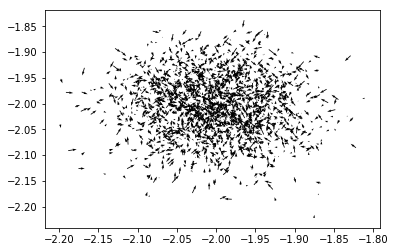

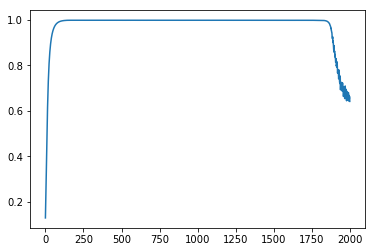

--------------


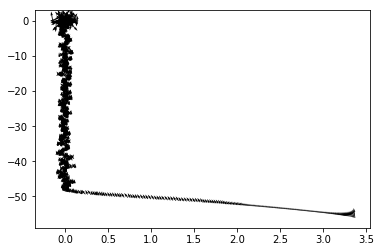

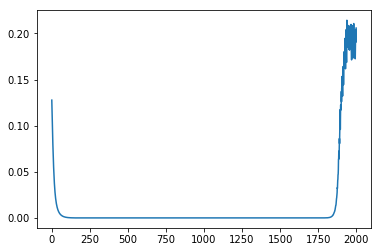

--------------


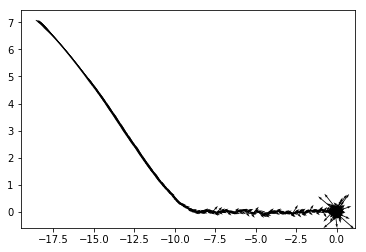

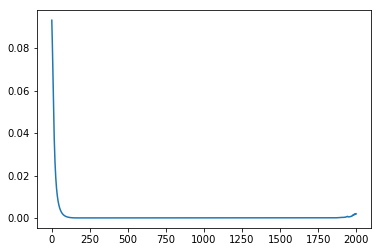

--------------


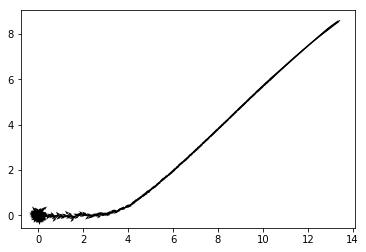

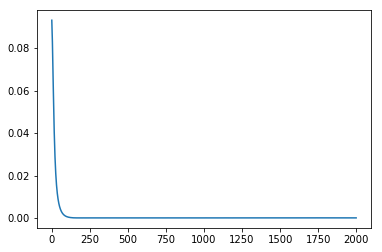

--------------


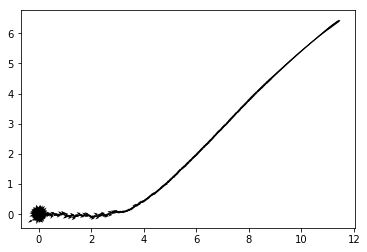

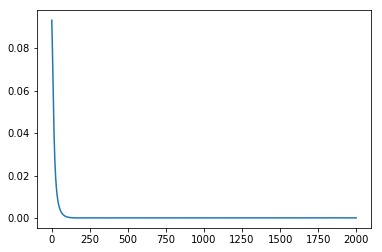

--------------


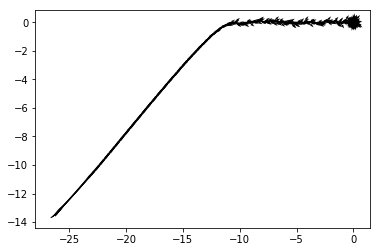

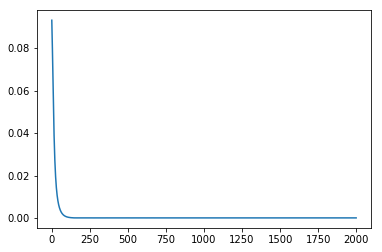

--------------


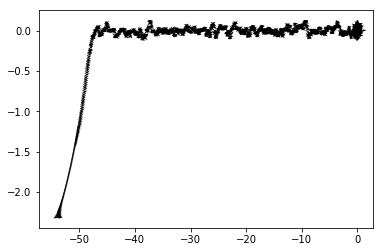

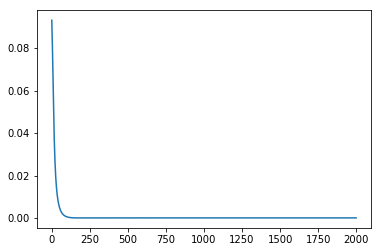

--------------


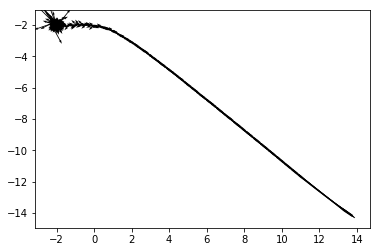

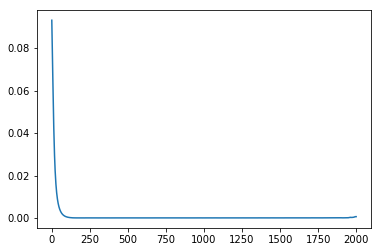

--------------


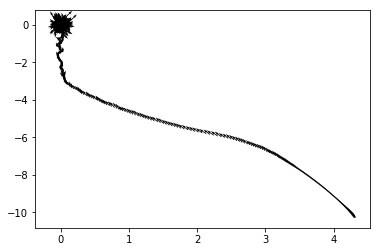

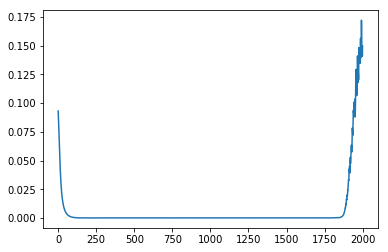

--------------


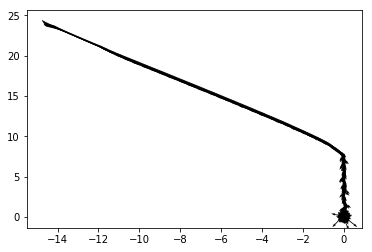

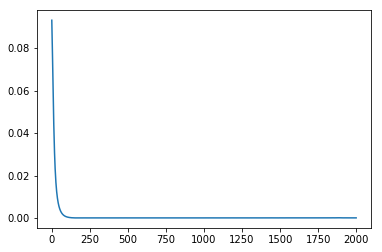

--------------


In [19]:
display(test_result_0)

Final loss: 1.7673404


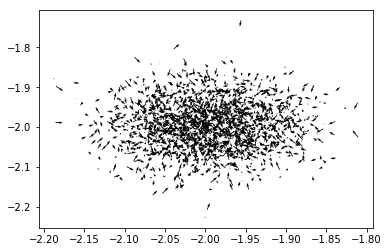

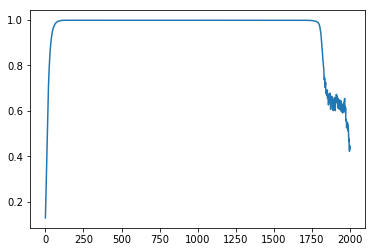

--------------


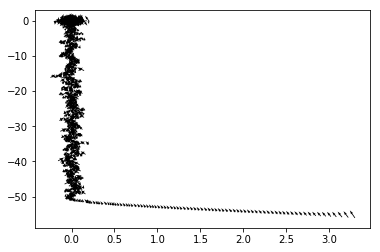

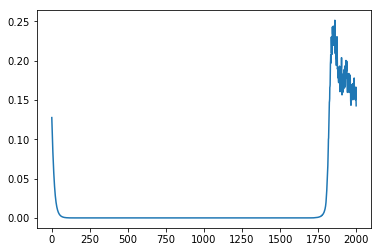

--------------


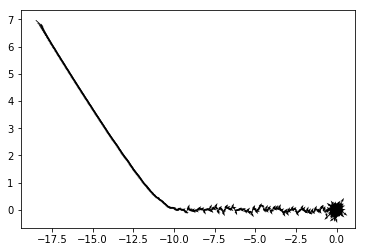

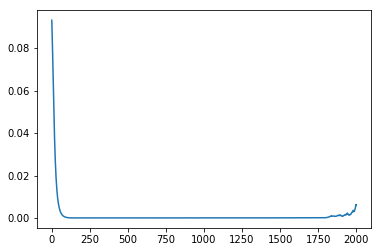

--------------


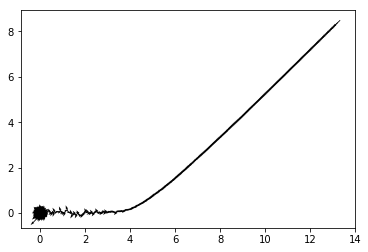

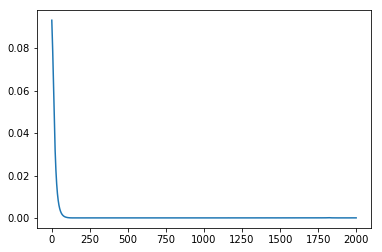

--------------


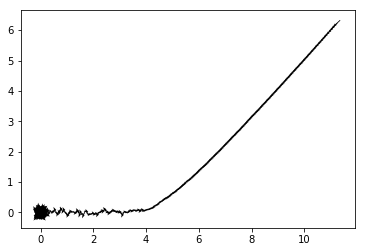

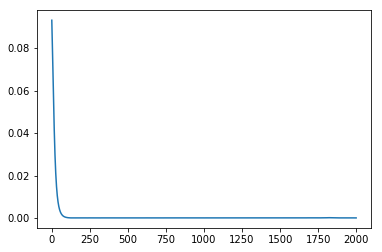

--------------


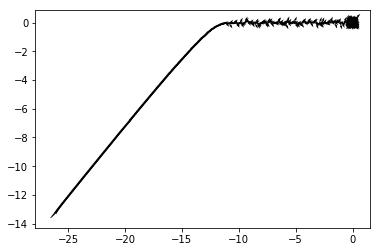

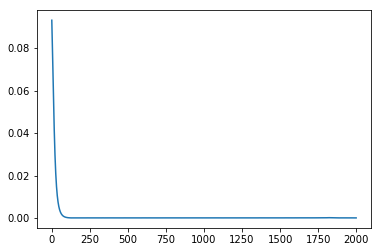

--------------


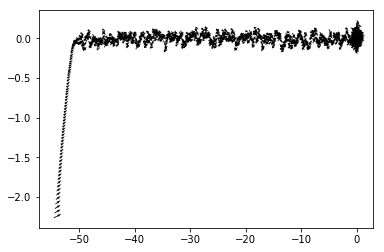

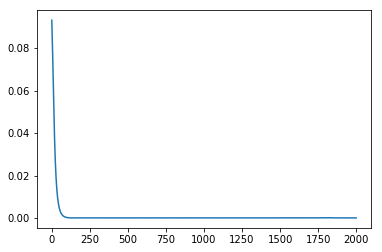

--------------


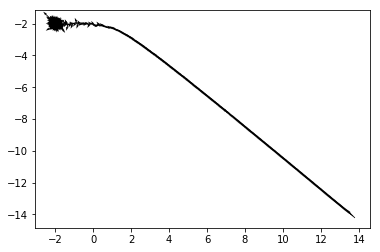

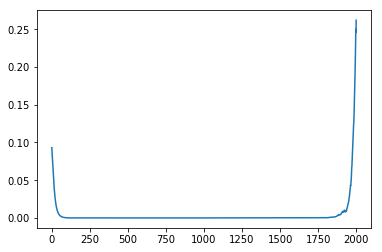

--------------


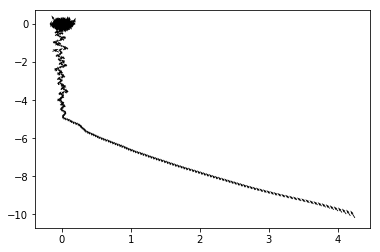

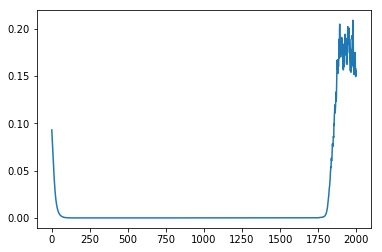

--------------


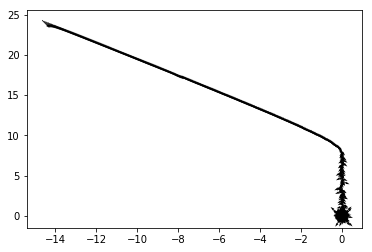

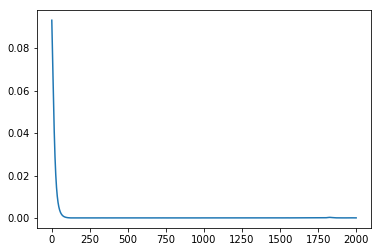

--------------


In [20]:
display(test_result_1)

In [ ]:
x = [i for i in range(100, 300)]
plt.plot(x, [test_result_0['loss'][i] for i in x], color='green')
plt.plot(x, [test_result_1['loss'][i] for i in x], color='red')
plt.show()

#### Conclusion

* The loss of $\beta = 1$ converges manifestly faster than that of $\beta = 0$.
* The final effect of $\beta = 1$ looks better than $\beta = 0$. But the improvement is little.

### Bad Initial Value

#### Configuration

In [42]:
n_d = 2
ones = np.ones([n_d]).astype('float32')
target_c = np.array([0.8, 0.2]).astype('float32')
target_mu = np.array([-2*ones, 2*ones]).astype('float32')
target_zeta = np.array([ones, ones, ones]).astype('float32')

n_c = 10
init_var = {
    'a': np.zeros([n_c]).astype('float32'),
    'mu': np.random.normal(0., 5., size=[n_c, n_d]).astype('float32'),
    'zeta': np.zeros([n_c, n_d]).astype('float32'),
}

init_var['mu'][0] = -2 * np.ones([n_d]).astype('float32')
init_var['mu'][1] = 2 * np.ones([n_d]).astype('float32')

tolerance = 1e-3
n_iters = 1000

#### Experiment

In [43]:
%%time

test_result = test(target_c, target_mu, target_zeta,init_var,
                   tolerance=tolerance, n_iters=n_iters)

99 0.0052702427
199 -0.0023329258
299 0.0071914196
399 0.008291006
499 0.0028824806
599 0.0017533302
699 0.006691695
799 0.0060038567
899 0.0034918785
999 -0.00040197372
CPU times: user 1h 2min 36s, sys: 12min 30s, total: 1h 15min 6s
Wall time: 24min 25s


In addition, as comparison:

In [48]:
%%time

test_result_0 = test(target_c, target_mu, target_zeta,init_var,
                     tolerance=tolerance, n_iters=n_iters, beta=0.0)

99 0.03711605
199 0.0007658005
299 0.0018932819
399 0.008018021
499 0.011873279
599 0.00040318523
699 0.013190764
799 0.009376527
899 0.0074477303
999 0.0005810931
CPU times: user 1h 5min 32s, sys: 12min 25s, total: 1h 17min 57s
Wall time: 8h 36min 34s


#### Visualization

Final loss: 0.0027717352


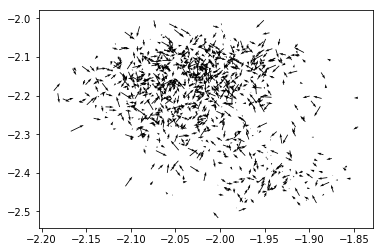

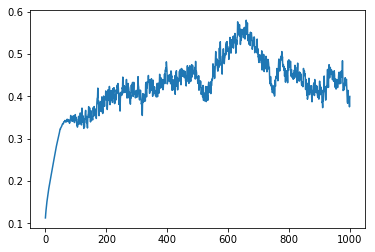

--------------


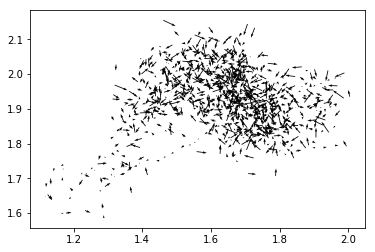

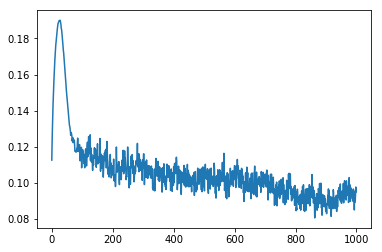

--------------


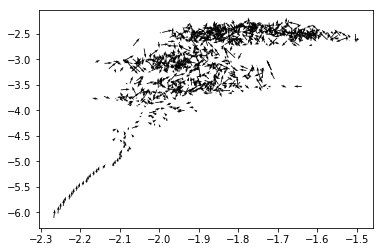

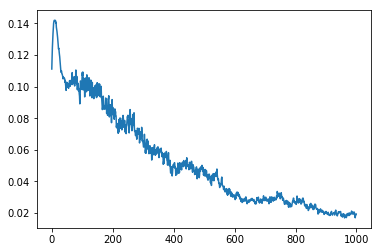

--------------


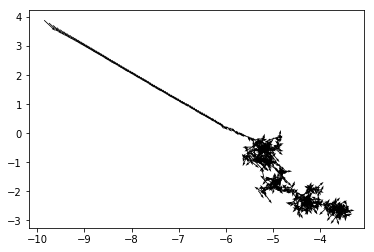

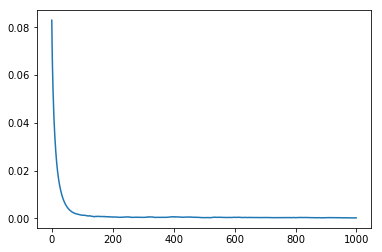

--------------


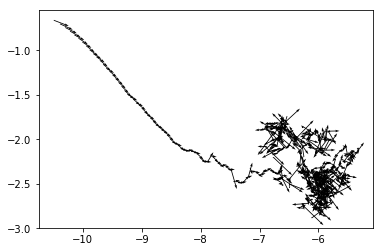

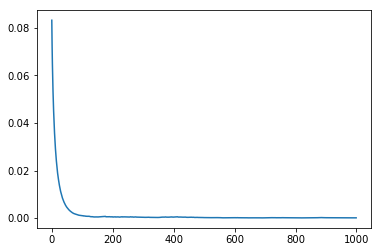

--------------


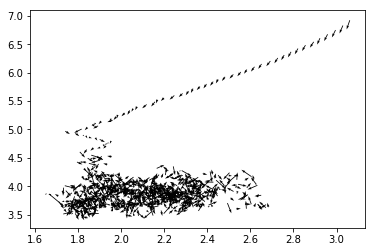

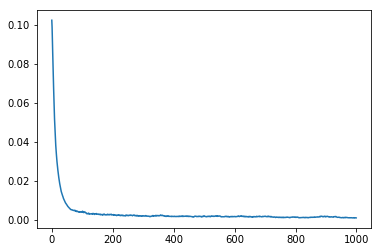

--------------


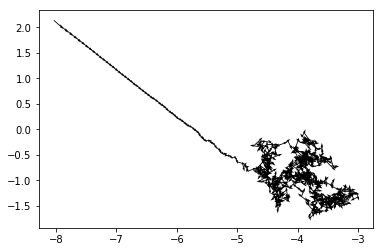

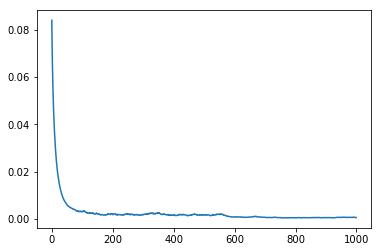

--------------


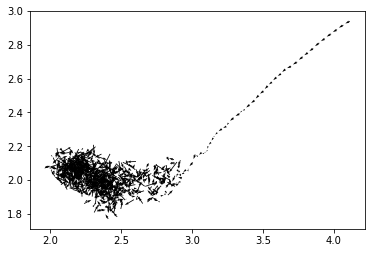

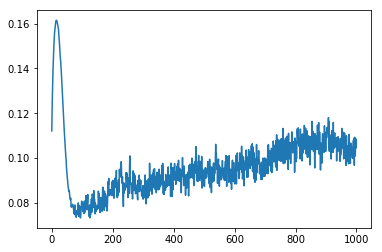

--------------


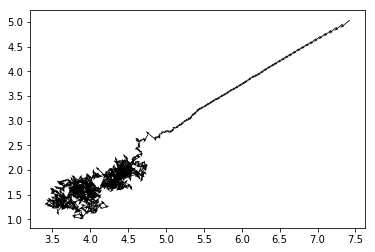

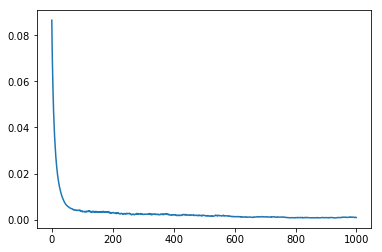

--------------


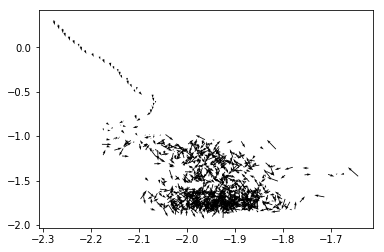

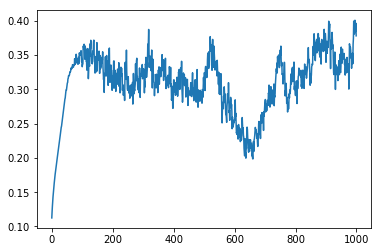

--------------


In [46]:
display(test_result)

Final loss: 0.0039085853


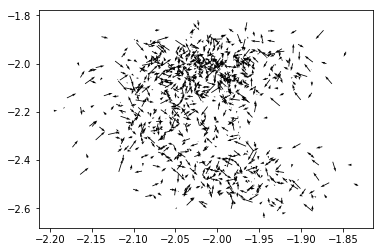

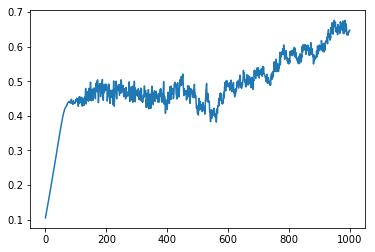

--------------


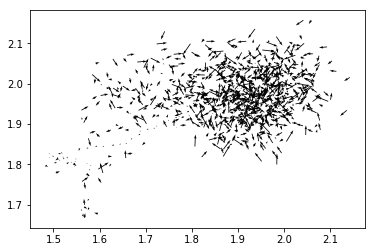

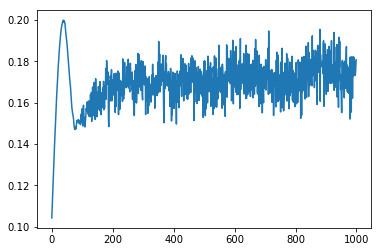

--------------


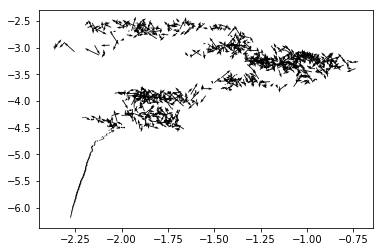

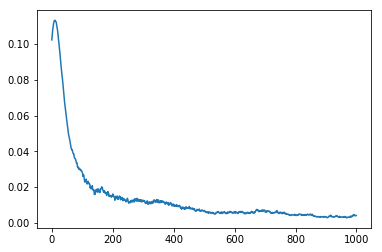

--------------


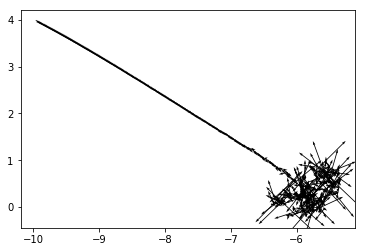

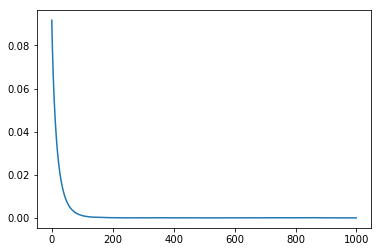

--------------


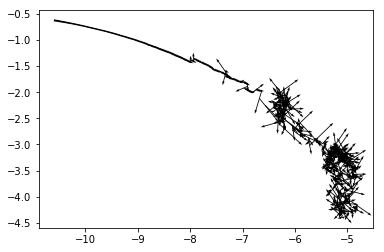

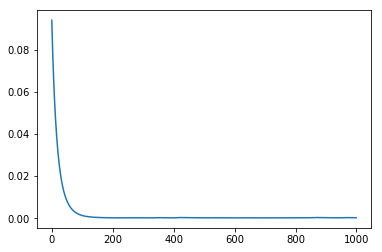

--------------


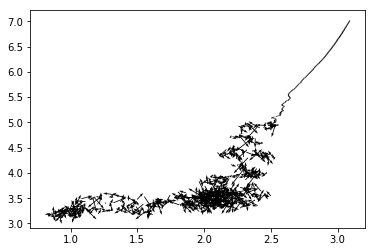

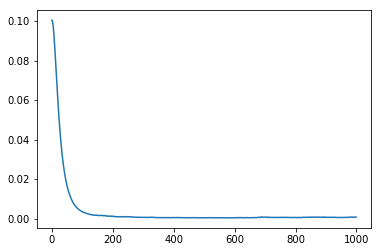

--------------


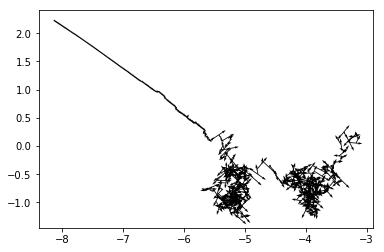

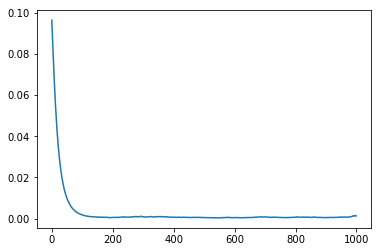

--------------


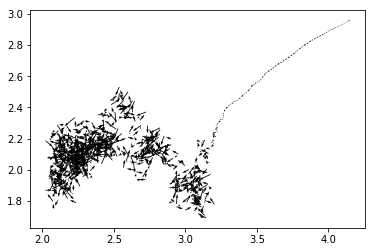

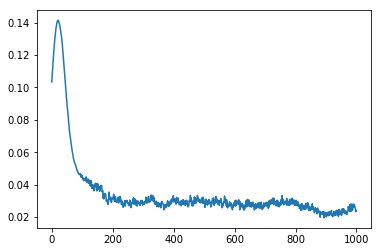

--------------


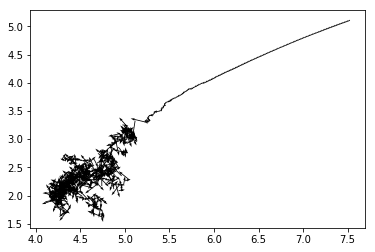

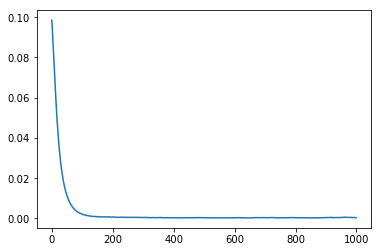

--------------


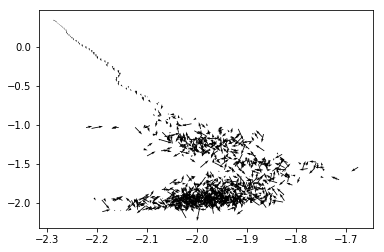

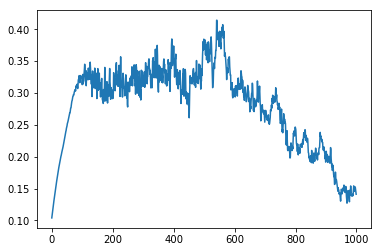

--------------


In [49]:
display(test_result_0)

#### Conclusion

* It's strange that the $c$ (when $\beta = 1$) does "evolve as itself", that is, it has no frozen-out phenomenon.
* However, when $\beta = 0$, it does become harder to "evolve as itself", as expected theoritically.